In this document, we investigate the neighbourhood of all labelled claims to have a grasp of the homophily in our network. 

This idea is based on what is done in the paper of Antonio et al.

# Loading the data

In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph

from tqdm.notebook import tqdm


%matplotlib inline

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
broker_nodes = pkl.load(open( "broker_nodes_brunosept.pkl", "rb" ))
cars_nodes = pkl.load(open( "cars_nodes_brunosept.pkl", "rb" ))
claims_nodes = pkl.load(open( "claims_nodes_brunosept.pkl", "rb" )).sort_values("ID")
policy_nodes = pkl.load(open( "policy_nodes_brunosept.pkl", "rb" ))
edges = pkl.load(open( "edges_brunosept.pkl", "rb" ))

labels = pd.DataFrame(pkl.load(open("Y", "rb"))).sort_values("SI01_NO_SIN")
labels.rename(columns = {"y1": "Fraud", "y2":"Labelled"}, inplace = True)

HG = StellarGraph({"claim" : claims_nodes, "car" : cars_nodes, "policy" : policy_nodes, "broker" : broker_nodes}, edges)

In [3]:
HG_claims = HG.nodes("claim")
HG_cars = HG.nodes("car")
HG_sub = list(HG_claims)+ list(HG_cars)
adjmat_claim_car = HG.to_adjacency_matrix(HG_sub)[:len(HG_claims), len(HG_claims):]

HG_policies = HG.nodes("policy")
HG_sub = list(HG_cars)+list(HG_policies)
adjmat_car_policy = HG.to_adjacency_matrix(HG_sub)[:len(HG_cars), len(HG_cars):]

C = adjmat_claim_car
P = adjmat_car_policy
CP = C @ P

A_bipartite = sp.sparse.hstack((C, CP)).tocsr()

In [4]:
nRows = A_bipartite.shape[0]
edges = {"source":[], "target":[], "weight":[]}

from tqdm.notebook import tqdm
for i in tqdm(range(nRows)):
    nonzeroIndices = A_bipartite[i, :].nonzero()
    for j in nonzeroIndices[1]:
        w = A_bipartite[i,j]
        edges["source"].append(i)
        edges["target"].append(j)
        edges["weight"].append(w)

  0%|          | 0/396146 [00:00<?, ?it/s]

In [5]:
df_edges = pd.DataFrame(edges)

party_index = np.concatenate((np.array(cars_nodes.index), np.array(policy_nodes.index)))
pd_party_index = pd.DataFrame(party_index)
pd_party_index.columns = ["party"]
pd_party_index["party_num"] = range(len(party_index))

pd_claim_index = pd.DataFrame(claims_nodes.index)
pd_claim_index.columns = ["claim"]
pd_claim_index["claim_num"] = range(len(claims_nodes.index))

pd_merged = pd_claim_index.merge(df_edges.merge(pd_party_index, how = "left", left_on = "target", right_on = "party_num"), left_on = "claim_num", right_on = "source")
pd_merged = pd_merged[["claim", "party", "weight"]]
pd_merged.columns = ["source", "target", "weight"]
pd_merged.head()

all_claims = pd.DataFrame(pd_claim_index['claim'])
all_claims.columns = ["ID"]
all_claims = all_claims.set_index("ID")

all_parties = pd.DataFrame(pd_party_index['party'])
all_parties.columns = ["ID"]
all_parties = all_parties.set_index("ID")

HG_bipartite = StellarGraph({"claim": all_claims, "party":all_parties},edges = pd_merged[["source", "target"]])

Nx_bipartite = HG_bipartite.to_networkx()

In [6]:
labels[labels["Fraud"]==1]

,Fraud,Labelled
SI01_NO_SIN,,
000020121000912,1,1.0
000020121002378,1,1.0
000020121002446,1,1.0
000020121002574,1,1.0
000020121002644,1,1.0
...,...,...
000020201004240,1,1.0
000020201009075,1,1.0
000020201011175,1,1.0


In [ ]:
fraudClaim_fraudNeighbours = []
fraudClaim_nonfraudNeighbours = []

nonfraudClaim_fraudNeighbours = []
nonfraudClaim_nonfraudNeighbours = []

for claim in tqdm(labels[labels["Labelled"] == 1].index): # Only look at labelled claims
    total_neighbour = 0.01
    fraud_neighbour = 0
    nonfraud_neighbour = 0
    
    neighbourhood = nx.generators.ego.ego_graph(Nx_bipartite, claim, radius = 2) # Radius 2 to get other claims
    for neighbour in neighbourhood:
        if neighbour in claims_nodes.index: # Only interested in claims in the neighbourhood
            if neighbour != claim: # Only interestes in neighbours
                total_neighbour += 1
                if neighbour in labels[labels["Labelled"] == 1].index:
                    if labels.loc[neighbour].Fraud ==1:
                        fraud_neighbour += 1
                    else:
                        nonfraud_neighbour += 1
    
    if labels.loc[claim].Fraud ==1:
        fraudClaim_fraudNeighbours.append(fraud_neighbour/total_neighbour)
        fraudClaim_nonfraudNeighbours.append(nonfraud_neighbour/total_neighbour)
    else:
        nonfraudClaim_fraudNeighbours.append(fraud_neighbour/total_neighbour)
        nonfraudClaim_nonfraudNeighbours.append(nonfraud_neighbour/total_neighbour)
    

  0%|          | 0/13311 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(fraudClaim_fraudNeighbours).to_csv("fraudClaim_fraudNeighbours.csv")
pd.DataFrame(fraudClaim_nonfraudNeighbours).to_csv("fraudClaim_nonfraudNeighbours.csv")
pd.DataFrame(nonfraudClaim_fraudNeighbours).to_csv("nonfraudClaim_fraudNeighbours.csv")
pd.DataFrame(nonfraudClaim_nonfraudNeighbours).to_csv("nonfraudClaim_nonfraudNeighbours.csv")

In [ ]:
fraudClaim_fraudNeighbours = pd.read_csv("fraudClaim_fraudNeighbours.csv")
fraudClaim_nonfraudNeighbours = pd.read_csv("fraudClaim_nonfraudNeighbours.csv")

nonfraudClaim_fraudNeighbours = pd.read_csv("nonfraudClaim_fraudNeighbours.csv")
nonfraudClaim_nonfraudNeighbours = pd.read_csv("nonfraudClaim_nonfraudNeighbours.csv")

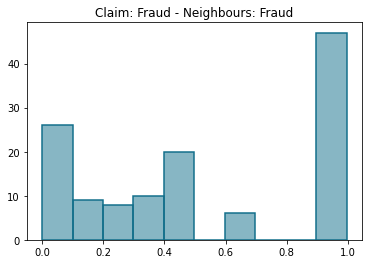

In [9]:
KULbg = "#116E8A" 
h=fraudClaim_fraudNeighbours[fraudClaim_fraudNeighbours["0"]>0]["0"]
plt.hist(h, color = KULbg, edgecolor= 'None', alpha = 0.5)
plt.hist(h, edgecolor=  KULbg, linewidth=1.5,facecolor="None")
plt.title("Claim: Fraud - Neighbours: Fraud")
plt.savefig("Fraud_Fraud.pdf")

In [10]:
np.mean(fraudClaim_fraudNeighbours["0"])

0.07889966898883234

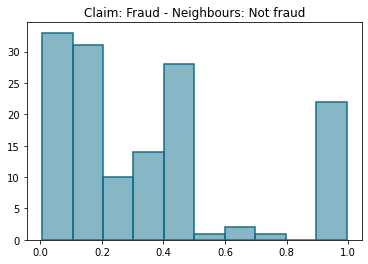

In [11]:
h=fraudClaim_nonfraudNeighbours[fraudClaim_nonfraudNeighbours["0"]>0]["0"]
plt.hist(h, color = KULbg, edgecolor= 'None', alpha = 0.5)
plt.hist(h, edgecolor=  KULbg, linewidth=1.5,facecolor="None")
plt.title("Claim: Fraud - Neighbours: Not fraud")
plt.savefig("Fraud_NonFraud.pdf")

In [12]:
np.mean(fraudClaim_nonfraudNeighbours["0"])

0.06241915389022633

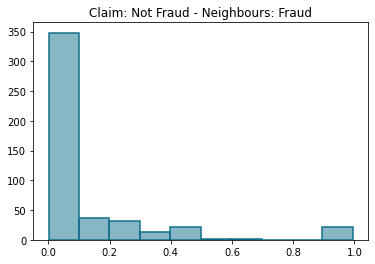

In [13]:
h=nonfraudClaim_fraudNeighbours[nonfraudClaim_fraudNeighbours["0"]>0]["0"]
plt.hist(h, color = KULbg, edgecolor= 'None', alpha = 0.5)
plt.hist(h, edgecolor=  KULbg, linewidth=1.5,facecolor="None")
plt.title("Claim: Not Fraud - Neighbours: Fraud")
plt.savefig("NonFraud_Fraud.pdf")

In [14]:
np.mean(nonfraudClaim_fraudNeighbours["0"])

0.0041660297521494945

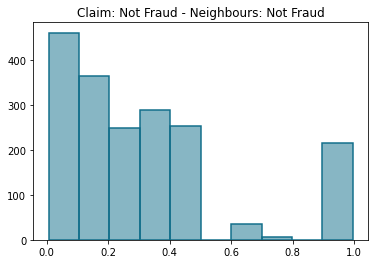

In [15]:
h=nonfraudClaim_nonfraudNeighbours[nonfraudClaim_nonfraudNeighbours["0"]>0]["0"]
plt.hist(h, color = KULbg, edgecolor= 'None', alpha = 0.5)
plt.hist(h, edgecolor=  KULbg, linewidth=1.5,facecolor="None")
plt.title("Claim: Not Fraud - Neighbours: Not Fraud")
plt.savefig("NonFraud_NonFraud.pdf")

In [16]:
np.mean(nonfraudClaim_nonfraudNeighbours["0"])

0.04810647734718591